In [101]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import helper
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import  silhouette_score

In [224]:
profiles = pd.read_json('../starbuck_capstone/data/profile.json',orient='records',lines=True)
transcripts = pd.read_json('../starbuck_capstone/data/transcript.json',orient='records',lines=True)
promotions = pd.read_json('../starbuck_capstone/data/portfolio.json',orient='records',lines=True)

In [225]:
 trans_dt, trans_clean_dt = helper.transaction_preprocessing(profiles,transcripts,promotions)

File load from local directory as it was already available


In [226]:
print('shape of trans_dt:',trans_dt.shape)
print('shape of trans_clean_dt:',trans_clean_dt.shape)

shape of trans_dt: (306534, 19)
shape of trans_clean_dt: (297057, 19)


In [227]:
final_df = helper.feature_engineering(trans_dt,trans_clean_dt, profiles, promotions)

## 1. EDA:

### 1.1 Missing Values: 

Text(0.5, 1.0, 'Missing Counts Per Column')

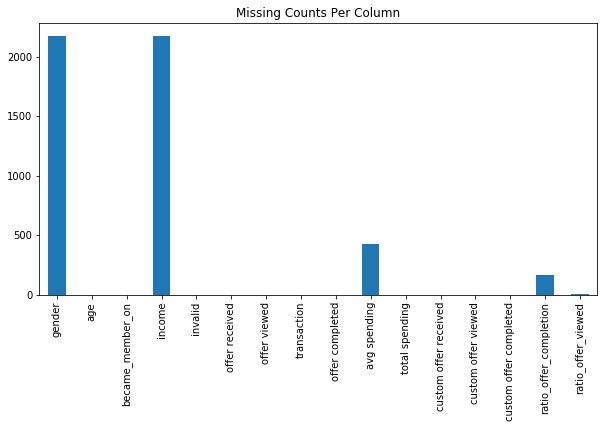

In [229]:
fig, ax = plt.subplots(figsize=(10,5))
final_df.isnull().sum().plot(kind='bar')
ax.set_title('Missing Counts Per Column')

## 2. Preprocessing

### 2.1 Missing Values:

In [230]:
(final_df.isnull().sum()/len(final_df))*100

gender                    12.794118
age                        0.000000
became_member_on           0.000000
income                    12.794118
invalid                    0.000000
offer received             0.000000
offer viewed               0.000000
transaction                0.000000
offer completed            0.000000
avg spending               2.482353
total spending             0.000000
custom offer received      0.000000
custom offer viewed        0.000000
custom offer completed     0.000000
ratio_offer_completion     0.976471
ratio_offer_viewed         0.035294
dtype: float64

In [231]:
## Fill out data with mean and mode (naive approach)
def fill_data(df,columns):
    """
    fill data based on mean (continuous) and mode (categorical)
    """
    for col in columns:
        if col == 'gender':
            mode = df.gender.mode()[0]
            df['gender'] = df['gender'].fillna(mode)
        else:
            if col in ['ratio_offer_completion','ratio_offer_viewed']:
                median = final_df[col].median()
                df[col] = df[col].fillna(median)
            else:
                mean = df[col].mean()
                df[col] = df[col].fillna(mean)
    return df

In [232]:
mis_cols = final_df.columns[final_df.isnull().sum() >0 ].tolist()
mis_cols

['gender',
 'income',
 'avg spending',
 'ratio_offer_completion',
 'ratio_offer_viewed']

In [233]:
final_df = fill_data(final_df,mis_cols)

In [234]:
final_df.isnull().sum()

gender                    0
age                       0
became_member_on          0
income                    0
invalid                   0
offer received            0
offer viewed              0
transaction               0
offer completed           0
avg spending              0
total spending            0
custom offer received     0
custom offer viewed       0
custom offer completed    0
ratio_offer_completion    0
ratio_offer_viewed        0
dtype: int64

### 2.2 One hot encoding for categorical features 

In [235]:
X = pd.get_dummies(final_df)
X 

,age,became_member_on,income,invalid,offer received,offer viewed,transaction,offer completed,avg spending,total spending,custom offer received,custom offer viewed,custom offer completed,ratio_offer_completion,ratio_offer_viewed,gender_F,gender_M,gender_O
68be06ca386d4c31939f3a4f0e3dd783,118,20170212,65404.991568,0.0,5.0,5.0,9.0,2.0,2.266667,20.40,5,5,2,0.400000,1.000000,0,1,0
0610b486422d4921ae7d2bf64640c50b,55,20170715,112000.000000,1.0,2.0,0.0,3.0,1.0,25.670000,77.01,2,0,0,0.400000,0.000000,1,0,0
38fe809add3b4fcf9315a9694bb96ff5,118,20180712,65404.991568,0.0,2.0,2.0,6.0,0.0,2.383333,14.30,2,2,0,0.000000,1.000000,0,1,0
78afa995795e4d85b5d9ceeca43f5fef,75,20170509,100000.000000,1.0,4.0,4.0,7.0,3.0,22.752857,159.27,4,4,2,0.500000,1.000000,1,0,0
a03223e636434f42ac4c3df47e8bac43,118,20170804,65404.991568,0.0,5.0,3.0,3.0,0.0,1.550000,4.65,5,3,0,0.000000,0.600000,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,45,20180604,54000.000000,0.0,3.0,3.0,7.0,0.0,2.861429,20.03,3,3,0,0.000000,1.000000,1,0,0
2cb4f97358b841b9a9773a7aa05a9d77,61,20180713,72000.000000,1.0,3.0,1.0,7.0,1.0,3.710000,25.97,3,1,0,0.000000,0.333333,0,1,0
01d26f638c274aa0b965d24cefe3183f,49,20170126,73000.000000,0.0,3.0,1.0,8.0,0.0,4.967500,39.74,3,1,0,0.000000,0.333333,0,1,0
9dc1421481194dcd9400aec7c9ae6366,83,20160307,50000.000000,2.0,3.0,3.0,14.0,3.0,13.547857,189.67,3,3,1,0.333333,1.000000,1,0,0


## 3. Clustering 

### 3.1 Clustering without any preprocessing (scaling and PCA)

In [24]:
from sklearn.decomposition import PCA

In [236]:

def pca_fit_transform(df, var = None):
    pca = PCA(var)
    transform_arr = pca.fit_transform(df)
    return pca, transform_arr


In [26]:
pca_main = PCA()
pca_main, pca_transform_main = pca_fit_transform(X, var=0.95)

In [140]:
pca_transform_main

array([[ 5.12335181e-01, -2.66568837e+00,  2.39584959e-01, ...,
        -9.30574049e-01, -7.44896201e-01,  7.30798763e-01],
       [-3.31814458e+00,  5.45253811e+00,  1.19606900e+00, ...,
        -7.85775961e-01,  1.09457571e-01, -5.62077384e-01],
       [-3.84034519e+00,  2.53974742e-01,  5.98986969e-01, ...,
         1.57641116e-01, -1.47812948e+00,  1.16184631e+00],
       ...,
       [-3.88960695e+00,  1.48510653e+00, -8.61635465e-01, ...,
        -3.68858421e-03,  4.77147176e-01, -1.95974527e-01],
       [ 3.89695062e-01,  1.91001740e+00,  3.24010420e-02, ...,
         1.88450690e+00, -1.56180691e+00,  9.67011758e-01],
       [-4.40433776e-01,  2.60858061e+00,  1.11215470e+00, ...,
        -2.83494879e-01,  9.74231880e-02,  2.02804191e-01]])

In [27]:


def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
#     for i in range(num_components):
#         ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')



Number of Main PCA components that explained at least 95% variance : 2


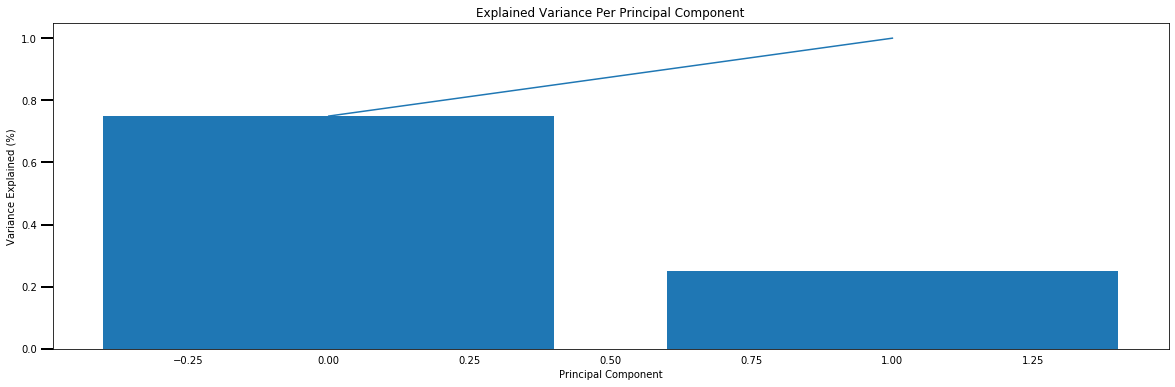

In [28]:
scree_plot(pca_main)

#PCA
# number of PCA components that explained at least 95% variance ==> 34 components
cumvals = np.cumsum(pca_main.explained_variance_ratio_)
print("Number of Main PCA components that explained at least 95% variance : {}".format(np.where(cumvals >= 0.95)[0][0]+1))

In [29]:
def plot_weight(df, pca, ith) :
    '''
    plot weight for the i-th principal component to corresponding feature names
    Input : 
        df = original dataframe
        pca = pca.fit(data)
        ith = int value, from 1 to len(pca.n_components)
    Return : axes of barplot 
    '''
    sort_pca = sorted([(weight, label) for weight,label in zip(pca.components_[ith-1], df.columns) ])
    weights, features = zip(*sort_pca)
    weights, features = list(weights), list(features)
    fig, ax = plt.subplots(figsize=(10,20))
    ax = sns.barplot(weights, features)
    return ax


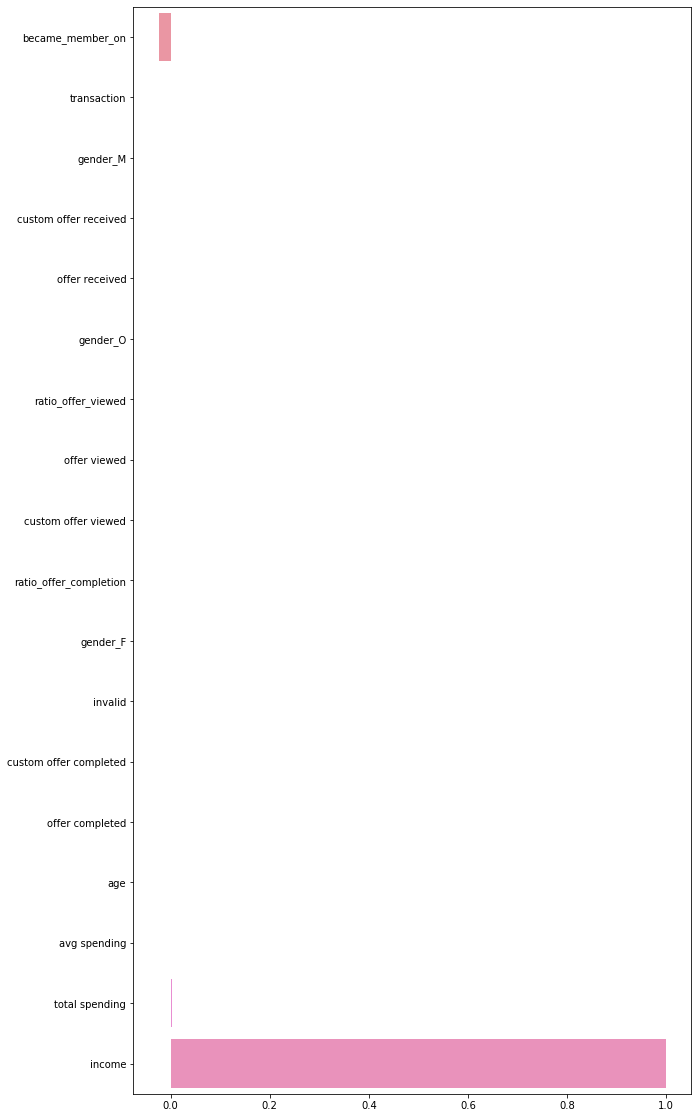

In [30]:
# 1st PCA comp
plot_weight(X,pca_main, 1 )

In [132]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import  silhouette_score
from tqdm import tqdm

def finding_num_cluster(X, min_clusters =2, max_clusters =30):
    silh = []
    inertia = []
    clusters = range(min_clusters,max_clusters)
    for n in tqdm(clusters):

        model = KMeans(n_clusters = n, random_state=42)
        preds = model.fit_predict(X)

        silhouette_avg = silhouette_score(X, preds)

        silh.append(silhouette_avg)
        inertia.append(model.inertia_)

    fig, (ax1,ax2) = plt.subplots(2,1, sharex=False, figsize=(8,7))
    ax1.plot(clusters, silh,marker="o")
    ax1.set_ylabel("Silhoutte Score")
    ax1.set_xlabel('number of clusters')
    ax2.plot(clusters, inertia, marker="o")
    ax2.set_ylabel("Inertia (SSE)")
    ax2.set_xlabel("number of clusters")
    plt.show()



100%|██████████| 28/28 [02:34<00:00,  5.52s/it]


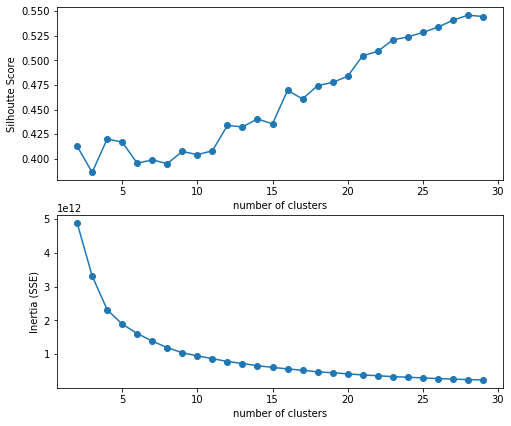

In [32]:
finding_num_cluster(pca_transform_main)

### 3.2 Clustering with preprocessing (Scaling)

In [237]:
from sklearn.preprocessing import StandardScaler

def perform_scaling(df):
    scaler = StandardScaler()
    std_arr = scaler.fit_transform(df)
    df_std = pd.DataFrame(std_arr, index=df.index, columns= df.columns)
    return df_std, scaler


In [238]:
profile_std_main, scaler_main = perform_scaling(X)

In [239]:
profile_std_main

,age,became_member_on,income,invalid,offer received,offer viewed,transaction,offer completed,avg spending,total spending,custom offer received,custom offer viewed,custom offer completed,ratio_offer_completion,ratio_offer_viewed,gender_F,gender_M,gender_O
68be06ca386d4c31939f3a4f0e3dd783,2.074539,0.272135,0.000000,-0.640907,0.476816,1.236432,0.161509,0.015425,-0.719840,-0.667401,0.476816,1.236432,0.434890,-0.028114,1.016400,-0.750862,0.771295,-0.112375
0610b486422d4921ae7d2bf64640c50b,-0.281677,0.315211,2.310264,0.508762,-2.310942,-2.616792,-1.011260,-0.607428,0.756176,-0.217826,-2.310942,-2.616792,-1.058973,-0.028114,-3.225617,1.331803,-1.296520,-0.112375
38fe809add3b4fcf9315a9694bb96ff5,2.074539,1.171327,0.000000,-0.640907,-2.310942,-1.075503,-0.424876,-1.230281,-0.712482,-0.715844,-2.310942,-1.075503,-1.058973,-1.151223,1.016400,-0.750862,0.771295,-0.112375
78afa995795e4d85b5d9ceeca43f5fef,0.466328,0.297570,1.715282,0.508762,-0.452437,0.465787,-0.229414,0.638278,0.572196,0.435452,-0.452437,0.465787,0.434890,0.252664,1.016400,1.331803,-1.296520,-0.112375
a03223e636434f42ac4c3df47e8bac43,2.074539,0.322833,0.000000,-0.640907,0.476816,-0.304858,-1.011260,-1.230281,-0.765039,-0.792481,0.476816,-0.304858,-1.058973,-1.151223,-0.680407,-0.750862,0.771295,-0.112375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,-0.655679,1.162078,-0.565480,-0.640907,-1.381690,-0.304858,-0.229414,-1.230281,-0.682329,-0.670339,-1.381690,-0.304858,-1.058973,-1.151223,1.016400,1.331803,-1.296520,-0.112375
2cb4f97358b841b9a9773a7aa05a9d77,-0.057275,1.171412,0.326992,0.508762,-1.381690,-1.846147,-0.229414,-0.607428,-0.628811,-0.623166,-1.381690,-1.846147,-1.058973,-1.151223,-1.811611,-0.750862,0.771295,-0.112375
01d26f638c274aa0b965d24cefe3183f,-0.506078,0.264770,0.376574,-0.640907,-1.381690,-1.846147,-0.033953,-1.230281,-0.549502,-0.513810,-1.381690,-1.846147,-1.058973,-1.151223,-1.811611,-0.750862,0.771295,-0.112375
9dc1421481194dcd9400aec7c9ae6366,0.765530,-0.576102,-0.763807,1.658431,-1.381690,-0.304858,1.138816,0.638278,-0.008351,0.676877,-1.381690,-0.304858,-0.312042,-0.215298,1.016400,1.331803,-1.296520,-0.112375


In [240]:
pca_main, pca_transform_main = pca_fit_transform(profile_std_main, var=0.95)

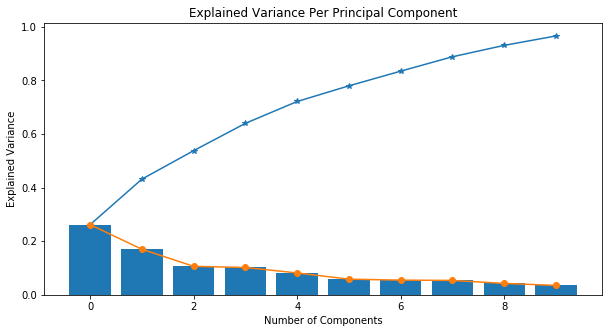

Number of Main PCA components that explained at least 95% variance : 10


In [241]:
scree_plot(pca_main)

#PCA
# number of PCA components that explained at least 95% variance ==> 34 components
cumvals = np.cumsum(pca_main.explained_variance_ratio_)
print("Number of Main PCA components that explained at least 95% variance : {}".format(np.where(cumvals >= 0.95)[0][0]+1))

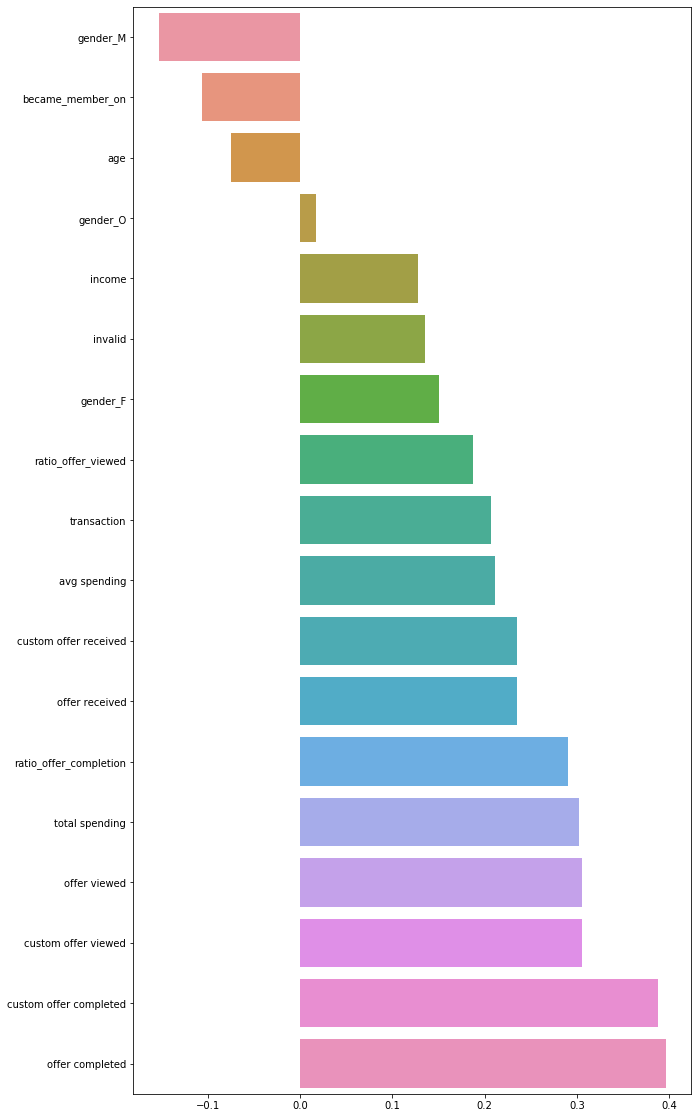

In [242]:
# 1st PCA comp
plot_weight(X,pca_main, 1 )

In [243]:
len(pca_main.components_)

10

100%|██████████| 9/9 [00:50<00:00,  5.56s/it]


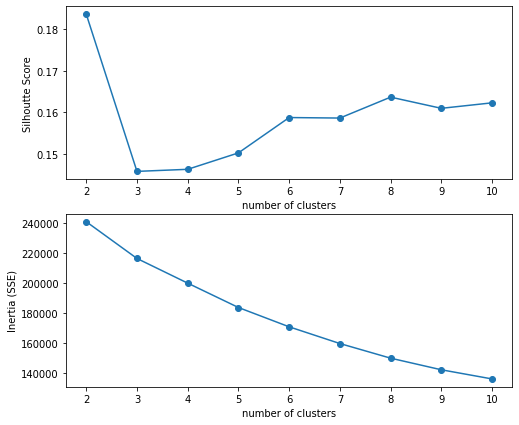

In [244]:
finding_num_cluster(pca_transform_main,max_clusters=11)

### 3.3 Clustering with my function 

In [45]:
## Scale and initialize PCA #

In [91]:
def scree_plot(pca):
    """
    draw a scree plot to determine the optimal components for pca 
    """
    # total number of components #
    num_components = len(pca.explained_variance_ratio_)
    # create array (size == number of components)
    components = np.arange(num_components)
    # variance of each component # 
    variance = np.array(pca.explained_variance_ratio_)
    # cumulative sum of variance #
    cum_variance = np.cumsum(variance)
    
    # time for plotting #
    plt.figure(figsize=(10,5))
    ax = plt.subplot(111)
    ax.bar(components, variance)
    ax.plot(components, cum_variance, marker="*")
    ax.plot(components, variance, marker="o")
    ax.set_title('Explained Variance Per Principal Component')
    ax.set_ylabel('Explained Variance')
    ax.set_xlabel('Number of Components')
    plt.show()
    

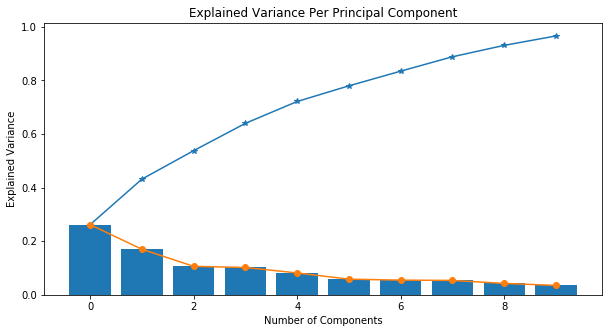

In [92]:
scree_plot(pca_main)

In [135]:
def evaluation_metric(features, min_cluster=2, max_cluster=20):
    """
    Determine the appropriate number of clusters based on different  
    standard metric such as inertia and silohutte
    """
    silhouette = []
    inertia = []
    clusters = range(min_cluster, max_cluster)
    for cluster in tqdm(clusters):
        K_means = KMeans(n_clusters = cluster)
        preds = K_means.fit_predict(features)
        silhouette.append(silhouette_score(features, preds))
        inertia.append(K_means.inertia_)
    metrics = [silhouette, inertia]
    titles = ['Silhouette score Per Cluster','Inertia (SSE) Per Cluster']
    y_labels = ['Silhouette score','Inertia (SSE)']
    # time for plotting #
    fig, axes = plt.subplots(nrows=2,figsize=(10,10))
    for ax,y,title,ylabel in zip(axes,metrics,titles,y_labels):
        ax.plot(clusters, y, marker='o')
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Number of Clusters')
        
        
        

100%|██████████| 18/18 [01:48<00:00,  6.06s/it]


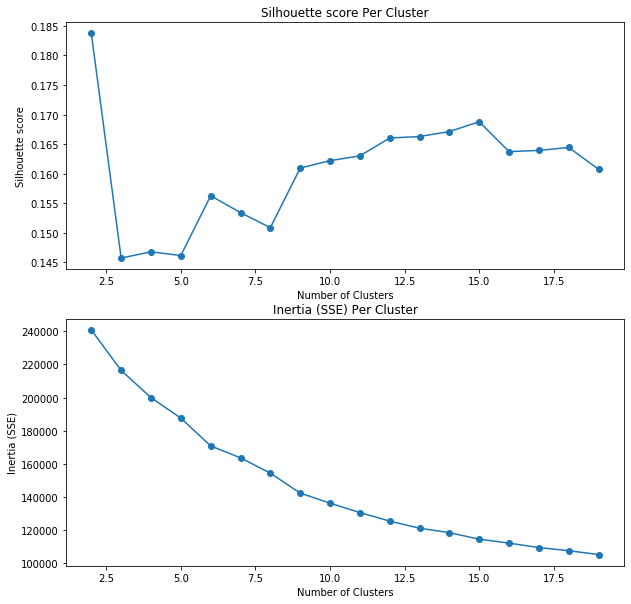

In [138]:
evaluation_metric(pca_transform_main, max_cluster=20)

In [245]:
### 3.4 Finally perform Kmean clustering (with 15 clusters)
k_means = KMeans(n_clusters=15)
preds_cluster = k_means.fit_predict(pca_transform_main)

In [149]:
final_df['Cluster'] = preds_cluster

## 4. Visualizing Clusters & Making Sense of it: 

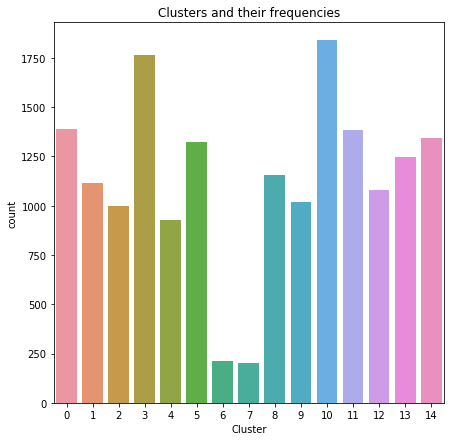

In [151]:
fig, ax = plt.subplots(figsize=(7,7))
sns.countplot(final_df['Cluster'])
ax.set_title('Clusters and their frequencies')
plt.show()

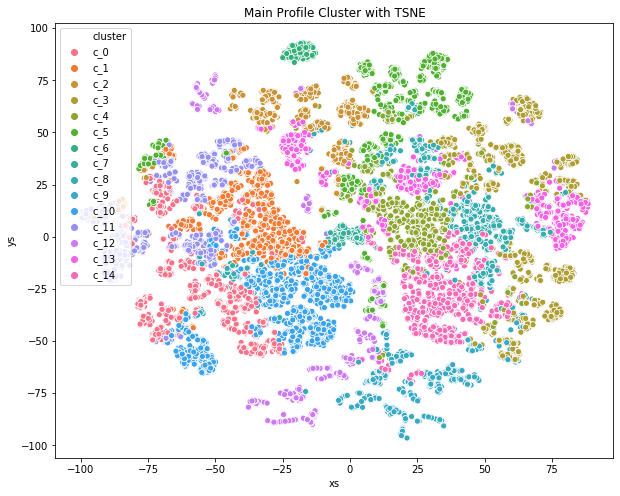

In [157]:
""" Visualise Cluster with TSNE"""
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42).fit_transform(pca_transform_main)
tsne_df = pd.DataFrame(tsne, columns=['xs', 'ys'])
tsne_df['cluster'] = ['c_' + str(i) for i in preds_cluster]

#plot tsne
f,ax = plt.subplots(figsize=(10,8))
sns.scatterplot('xs','ys', hue='cluster', data=tsne_df, ax=ax, hue_order=['c_' + str(i) for i in range(0,15)])
ax.set_title("Main Profile Cluster with TSNE")
#save fig
f.savefig('main_tsne.png', dpi = 300)

In [257]:
""" Cluster Centroid """

def inverse_transform_centroid(df, kmeans, pca, scaler):
    """ 
    INPUT : 
        df : dataframe
        kmeans : sklearn object of fitted KMeeans
        pca : sklearn object of fitted PCA
        scaler : sklearn object of fitted Scaler
    RETUNR :
        centers : dataframe of center value each cluster
    """
    centers = kmeans.cluster_centers_
    centers_pca = pca.inverse_transform(centers)
    centers = scaler.inverse_transform(centers_pca)
    centers = pd.DataFrame(centers, columns= df.columns)
    return centers

In [276]:
pd.set_option('display.max_columns', 500)
profile_main = final_df.copy()
profile_main_centroid = inverse_transform_centroid(X, k_means, pca_main, scaler_main)
profile_main_centroid

,age,became_member_on,income,invalid,offer received,offer viewed,transaction,offer completed,avg spending,total spending,custom offer received,custom offer viewed,custom offer completed,ratio_offer_completion,ratio_offer_viewed,gender_F,gender_M,gender_O
0,54.815692,2.017181e+07,61334.665631,0.444778,4.124712,2.032321,4.807875,0.608507,10.818147,39.648371,4.124712,2.032321,0.163729,0.203276,0.519556,1.000039,-0.000013,-0.000026
1,116.508274,2.016860e+07,65821.052963,0.032015,4.918888,4.238792,7.006824,0.525896,3.490334,18.005549,4.918888,4.238792,0.493881,0.058720,0.873436,-0.000015,1.000018,-0.000003
2,57.781506,2.017353e+07,69276.466846,0.297902,4.896737,4.389725,5.005971,1.536923,14.517867,71.924680,4.896737,4.389725,1.239021,0.234648,0.911724,0.999935,0.000049,0.000016
3,62.335638,2.017019e+07,55844.399018,0.321537,4.276905,1.506429,5.773472,0.446854,6.194555,18.385243,4.276905,1.506429,0.125317,0.257306,0.372964,-0.000267,1.000147,0.000120
4,56.566145,2.016489e+07,69896.229052,0.320063,3.673310,3.246636,9.004205,2.756141,17.425706,143.673377,3.673310,3.246636,2.436079,0.729990,0.867428,0.000052,0.999960,-0.000012
5,57.189533,2.016414e+07,70547.809336,0.592293,5.124188,4.595037,11.416475,3.864823,19.771699,191.596378,5.124188,4.595037,3.272529,0.809454,0.916360,0.999881,0.000059,0.000060
6,56.627586,2.016551e+07,67804.448121,0.511733,5.448920,4.957355,10.910884,3.674793,16.442060,161.772681,5.448920,4.957355,3.163059,0.730712,0.939209,-0.000377,1.000215,0.000162
7,54.608135,2.016767e+07,62536.800088,0.456354,4.316667,3.641282,8.270676,2.367976,14.661757,120.394585,4.316667,3.641282,1.911622,0.511460,0.844862,0.000141,-0.000076,0.999935
8,54.663560,2.016899e+07,95501.700161,0.735591,4.653692,3.744069,11.818233,3.139175,111.925060,860.986970,4.653692,3.744069,2.403585,0.611830,0.804495,0.517461,0.476219,0.006320
9,56.538450,2.016526e+07,75468.738808,2.169034,4.991493,3.116226,9.608910,3.661973,19.632922,171.318480,4.991493,3.116226,1.492939,0.467020,0.612062,-0.000015,0.999997,0.000018


In [264]:
def compare_features(df, features, xlabel = 'cluster', ylabel = 'std value', figsize = (10,8)):
    """ This function is just to plot selected features"""
    n_cols = len(features)
    rows = n_cols//2 + (n_cols % 2 >0)
    
    f, axs = plt.subplots(rows,2, figsize=figsize)
    axs = axs.flatten()

    for i in range(n_cols):
        sns.barplot(df.index,features[i], data= df, ax= axs[i])
        axs[i].set_xlabel(xlabel)
        axs[i].set_ylabel(ylabel)
        axs[i].set_title('Feature : ' + features[i])
        
    plt.tight_layout()

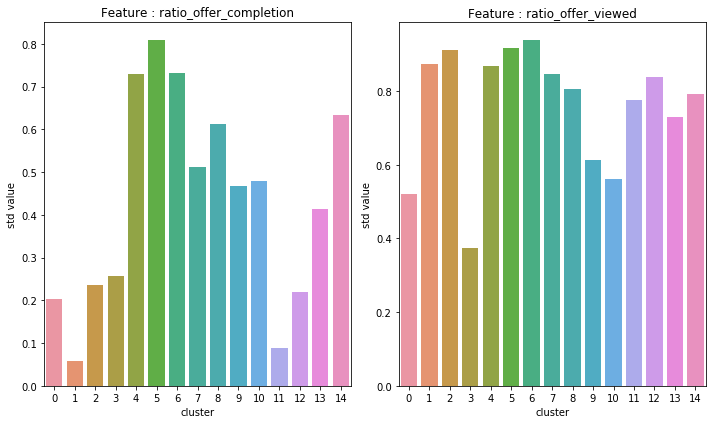

In [266]:
""" Visualize completed rate for each offer and cluster"""

features = [
    'ratio_offer_completion',
    'ratio_offer_viewed']

compare_features(profile_main_centroid, features, figsize=(10,6))

In [270]:
profile_main_centroid.columns

Index(['age', 'became_member_on', 'income', 'invalid', 'offer received',
       'offer viewed', 'transaction', 'offer completed', 'avg spending',
       'total spending', 'custom offer received', 'custom offer viewed',
       'custom offer completed', 'ratio_offer_completion',
       'ratio_offer_viewed', 'gender_F', 'gender_M', 'gender_O'],
      dtype='object')

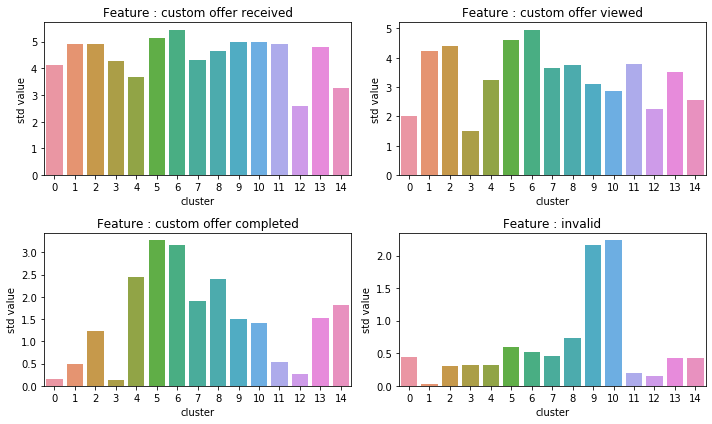

In [279]:
""" Visualize completed rate for each offer and cluster"""

features = [
     'custom offer received', 'custom offer viewed',
       'custom offer completed','invalid']

compare_features(profile_main_centroid, features, figsize=(10,6))

One trend is quite visible, those who are regular customers (invalid ==0) may receive, viewed but don't complete offer (in above case 11,12,1 cluster) whereas in other cases (such as cluster 4,5,6,7,8) customers look for offers they recieve, view and complete it. 

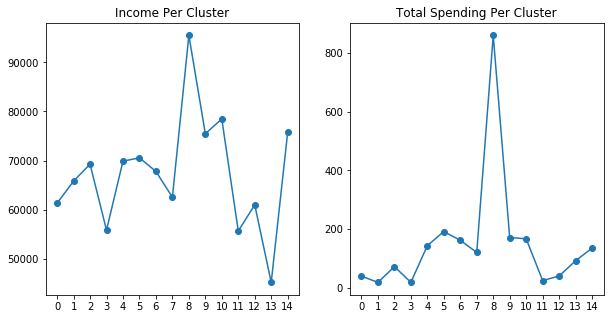

In [295]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(10,5))
ax1.plot(profile_main_centroid.index, profile_main_centroid.income, marker='o')
ax1.set_title('Income Per Cluster')
ax1.set_xticks([i for i in range(0,15)])
ax2.plot(profile_main_centroid.index, profile_main_centroid['total spending'], marker='o')
ax2.set_title('Total Spending Per Cluster')
ax2.set_xticks([i for i in range(0,15)])
plt.show()

In [195]:
temp = final_df.copy()

In [196]:
temp = temp[(temp['invalid']==0)]

In [197]:
agg =temp.groupby(by=['Cluster'])['custom offer completed'].sum().reset_index()

Text(0.5, 1.0, 'Total offer Completed Per Cluster (Valid)')

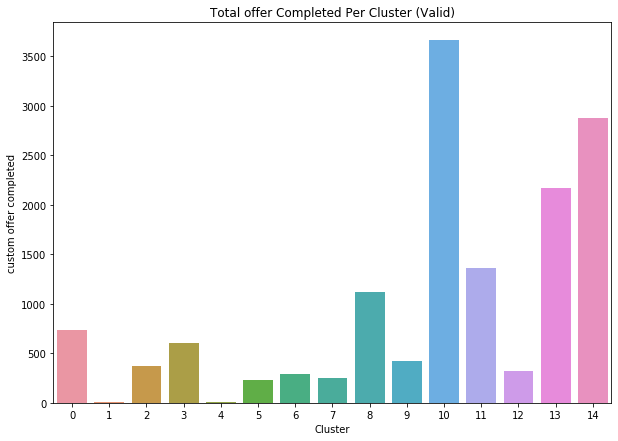

In [198]:
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(x='Cluster',y='custom offer completed',data=agg)
ax.set_title('Total offer Completed Per Cluster (Valid)')

In [199]:
agg =temp.groupby(by=['Cluster'])['avg spending'].sum().reset_index()

Text(0.5, 1.0, 'Avg spending Per Cluster (Valid)')

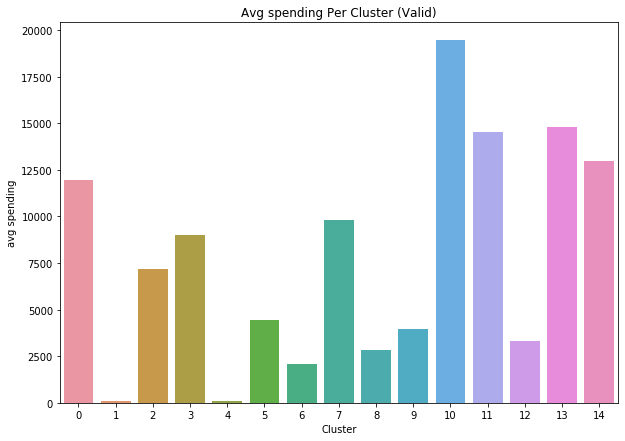

In [201]:
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(x='Cluster',y='avg spending',data=agg)
ax.set_title('Avg spending Per Cluster (Valid)')

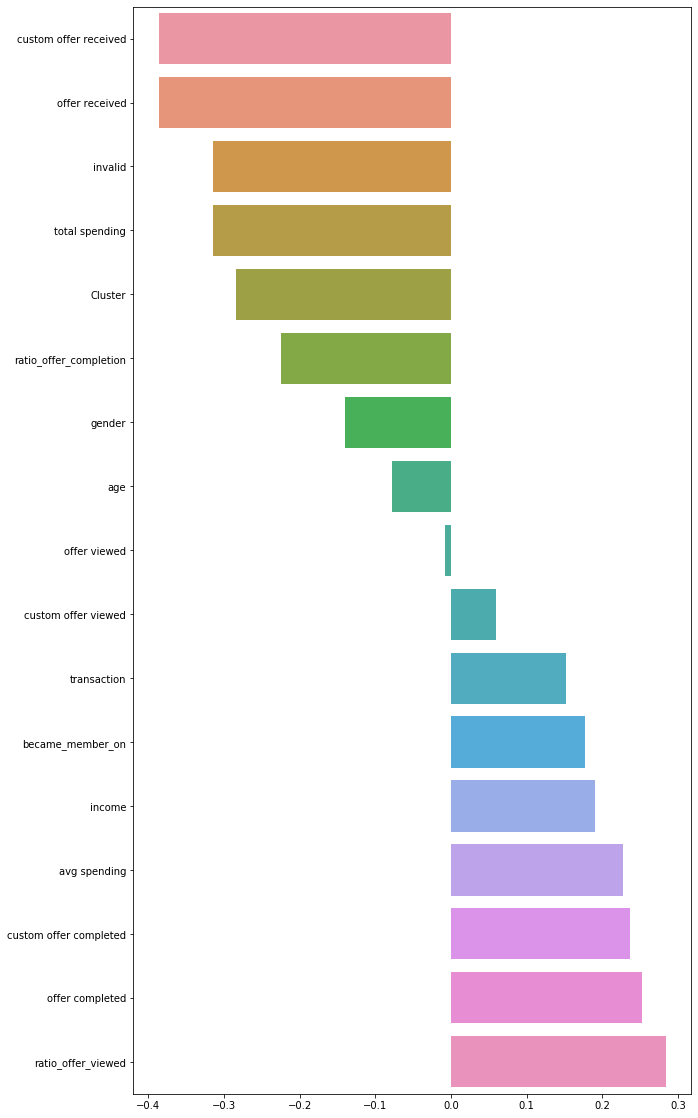

In [163]:
plot_weight(final_df,pca_main, 2)